<a href="https://colab.research.google.com/github/ShotaArima/task-wind-to-ep/blob/main/Final_Task(iwano_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# モジュールのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.api.models import Sequential
from keras.api.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
# データの読み込み
f = open('/content/drive/MyDrive/class/知能科学/wind_data_s.csv')
df = pd.read_csv(f)
xy = df.loc[:,['x1', 'x2', 'y']].values

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0266 - mean_absolute_error: 0.0788 - val_loss: 0.0054 - val_mean_absolute_error: 0.0391
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237 - mean_absolute_error: 0.0795 - val_loss: 0.0054 - val_mean_absolute_error: 0.0481
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0241 - mean_absolute_error: 0.0941 - val_loss: 0.0059 - val_mean_absolute_error: 0.0556
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0186 - mean_absolute_error: 0.0871 - val_loss: 0.0064 - val_mean_absolute_error: 0.0616
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0229 - mean_absolute_error: 0.0924 - val_loss: 0.0069 - val_mean_absolute_error: 0.0656
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mean_absolute_error: 0.0879 - val_loss: 0.0071 - val_mean_absolute_error: 0.0674
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - mean_absolute_error: 0.0996 - val_loss

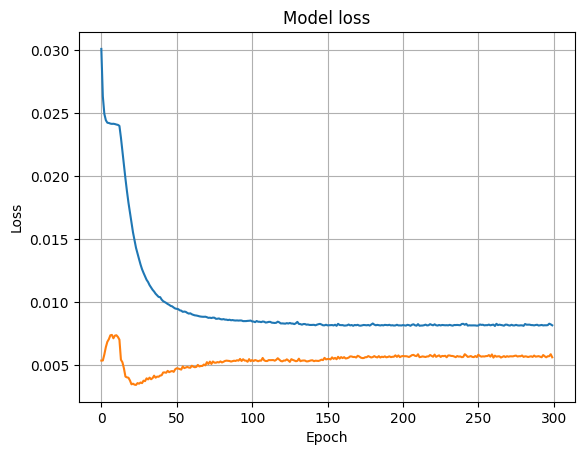

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[ 1.43242298e+01  1.74232004e+01  1.13761797e+01  9.69463909e+00
  8.12628877e+00  5.02731824e+00  2.02580575e+01  1.60435033e+01
  1.73100073e+01  1.13761797e+01  1.58171200e+01  1.59303102e+01
  5.21597147e+00  1.26049564e+01  6.67113149e+00  9.58144605e+00
 -1.39700615e+00 -5.91340935e+00  3.15712166e+00  9.50598586e+00
  1.11875292e+01  3.57215822e+00 -2.73897588e+00  1.70196164e+00
  1.81515467e+00  6.40701532e+00  6.52020562e+00  8.05082583e+00
  6.55793846e+00  4.98958814e+00  6.48247552e+00  8.05082583e+00
 -6.13978994e+00 -1.43473899e+00  7.86217535e+00  9.61917615e+00
  1.11875292e+01  8.16401887e+00  8.08855867e+00  1.57416598e+01
 -1.86488651e+01 -1.24509240e+01 -1.07693807e+01 -1.73090696e-02
  9.43052566e+00  6.59566855e+00  6.52020562e+00 -4.19413316e+00
 -3.00308931e+00  4.76320481e+00 -2.70124304e+00  1.71341419e-01
  3.30804479e+00  4.91412795e+00  1.89061487e+00  1.81515467e+00
  1.71341419e-01  1.77742457e+00  3.34577489e+00  3.

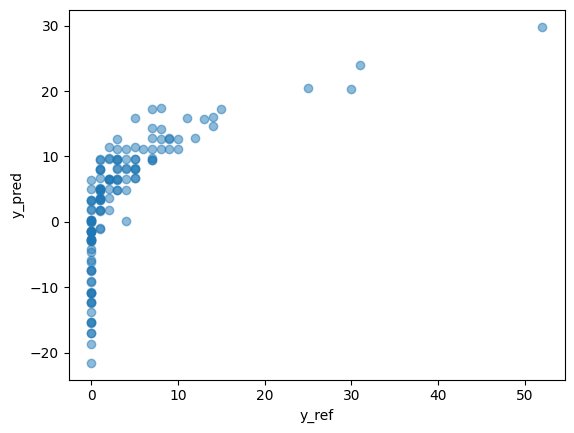

In [3]:
# データの正規化
scaler = MinMaxScaler()
norm_xy = scaler.fit_transform(xy)
#print(norm_xy)

# 学習データと評価データの準備
norm_x = norm_xy[:, 0:2]
norm_y = norm_xy[:, 2]
x_train = norm_x[:304]
x_test = norm_x[304:440]
y_train = norm_y[:304]
y_test = norm_y[304:440]
#print(x_train)
#print(x_train.shape)
#print(y_train)
#print(y_train.shape)
#print(x_test)
#print(x_test.shape)
#print(y_test)
#print(y_test.shape)

# ニューラルネットワークの構築
input_nnode = 2    # 入力層のノード数
mid1_nnode = 4     # １番目の中間層のノード数
#mid2_nnode = 2     # ２番目の中間層のノード数
output_nnode = 1   # 出力層のノード数
model = Sequential()
model.add(Dense(mid1_nnode, activation='relu', input_dim=input_nnode))
#model.add(Dense(mid2_nnode, activation='relu'))
model.add(Dense(output_nnode, activation='linear'))
model.summary()

# ネットワークの最適化（学習）
model.compile(optimizer='adam',
   loss='mean_squared_error',
   metrics=['mean_absolute_error'])

train_history = model.fit(x_train, y_train,
   batch_size=8,
   epochs=300,
   verbose=1,
   validation_data=(x_test, y_test))

# 学習経過の表示
train_history.history.keys()
print(train_history.history)
len(train_history.history['loss'])

# 損失関数値のプロット
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

# 評価データによる推定と逆正規化
norm_y_pred = model.predict(x_test)
#print(norm_y_pred)
norm_xy_pred = np.hstack((x_test, norm_y_pred))
xy_pred = scaler.inverse_transform(norm_xy_pred)

# 最終的な推定値と正解値の表示
y_pred = xy_pred[:, 2]
y_ref = xy[304:440, 2]
print(y_pred)
print(y_ref)
fig, ax = plt.subplots()
ax.scatter(y_ref, y_pred, alpha=0.5)
ax.set_xlabel('y_ref')
ax.set_ylabel('y_pred')
plt.show()